(ch:45p_preproc)=
# 45P Spectroscopic Preprocessing 
This is a note demonstrating the preprocessing of longslit spectroscopy data for 45P. The resulting preprocessed data will be used for a spectroscopic example lecture note in {ref}`ch:specexample`.

```{note}
I emphasize again that this lecture note does not teach preprocessing. If preprocessing-related lecture is required, I recommend [Matthew Craig's CCD Data Reduction Guide](https://www.astropy.org/ccd-reduction-and-photometry-guide/v/dev/notebooks/00-00-Preface.html).
```

In [114]:
# %matplotlib notebook
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'last_expr' 
import numpy as np
from astropy.nddata import CCDData
from matplotlib import pyplot as plt
from astropy.stats import sigma_clipped_stats

# We need to do it in a separate cell. See:
# https://github.com/jupyter/notebook/issues/3385
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'latin modern math', 'font.size':12, 'mathtext.fontset':'stix', 
    'axes.formatter.use_mathtext': True, 'axes.formatter.limits': (-4, 4),
    'axes.grid': True, 'grid.color': 'gray', 'grid.linewidth': 0.5, 
    'xtick.top': True, 'ytick.right': True, 
    'xtick.direction': 'inout', 'ytick.direction': 'inout',
    'xtick.minor.size': 2.0, 'ytick.minor.size': 2.0,  # default 2.0
    'xtick.major.size': 4.0, 'ytick.major.size': 4.0,  # default 3.5
    'xtick.minor.visible': True, 'ytick.minor.visible': True
})
import ysfitsutilpy as yfu
from pathlib import Path

import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.filterwarnings('ignore', append=True, category=AstropyWarning)

DATAPATH = Path('../../Tutorial_Data/45P/rawdata')
CALPATH = Path('../../Tutorial_Data/45P/calib')
REDPATH = Path('../../Tutorial_Data/45P/reduced')
CALPATH.mkdir(exist_ok=True, parents=True)
REDPATH.mkdir(exist_ok=True, parents=True)

USEFUL_KEYWORDS = ["FILE_ID", "DATE-OBS", "EXPTIME", "OBJECT", "IMAGETYP", "AIRMASS", 
                   "ALTITUDE", "AZIMUTH", "GRATING", "ORDERCUT", "SLIT-WID", ]

TRIMSEC = '[:, 250:1300]'  # for 45P

summary = yfu.make_summary(DATAPATH/"**.fits", verify_fix=True, keywords=USEFUL_KEYWORDS, verbose=0)
summary

file  filesize  FILE_ID  \
0   ../../Tutorial_Data/45P/rawdata/mls170213_0001...   8876160        1   
1   ../../Tutorial_Data/45P/rawdata/mls170213_0002...   8876160        2   
2   ../../Tutorial_Data/45P/rawdata/mls170213_0003...   8876160        3   
3   ../../Tutorial_Data/45P/rawdata/mls170213_0004...   8876160        4   
4   ../../Tutorial_Data/45P/rawdata/mls170213_0005...   8876160        5   
..                                                ...       ...      ...   
81  ../../Tutorial_Data/45P/rawdata/mls170213_0082...   8876160       82   
82  ../../Tutorial_Data/45P/rawdata/mls170213_0083...   8876160       83   
83  ../../Tutorial_Data/45P/rawdata/mls170213_0084...   8876160       84   
84  ../../Tutorial_Data/45P/rawdata/mls170213_0085...   8876160       85   
85  ../../Tutorial_Data/45P/rawdata/mls170213_0086...   8876160       86   

               DATE-OBS  EXPTIME    OBJECT     IMAGETYP  AIRMASS  ALTITUDE  \
0   2017-02-13T16:18:19      5.0  HD129184  Light Frame    1.696  36.06507   
1   2017-02-13T16:20:04     20.0  HD129184  Light Frame    1.681  36.42363   
2   2017-02-13T16:21:28     20.0  HD129184  Light Frame    1.670  36.70704   
3   2017-02-13T16:22:20     20.0  HD129184  Light Frame    1.663  36.88638   
4   2017-02-13T16:23:13     20.0  HD129184  Light Frame    1.656  37.06552   
..                  ...      ...       ...          ...      ...       ...   
81  2017-02-13T23:12:10    600.0      DARK   Dark Frame    1.000  89.98500   
82  2017-02-13T23:22:44    600.0      DARK   Dark Frame    1.000  89.98500   
83  2017-02-13T23:33:16    600.0      DARK   Dark Frame    1.000  89.98500   
84  2017-02-13T23:43:51    600.0      DARK   Dark Frame    1.000  89.98500   
85  2017-02-13T23:54:19    600.0      DARK   Dark Frame    1.000  89.98500   

     AZIMUTH  GRATING ORDERCUT  SLIT-WID  
0  -87.65540      150    WG320       1.6  
1  -87.39473      150    WG320       1.6  
2  -87.18750      150    WG320       1.6  
3  -87.05611      150    WG320       1.6  
4  -86.92411      150    WG320       1.6  
..       ...      ...      ...       ...  
81   0.00001      150    WG320       1.6  
82   0.00001      150    WG320       1.6  
83   0.00001      150    WG320       1.6  
84   0.00001      150    WG320       1.6  
85   0.00001      150    WG320       1.6  

[86 rows x 13 columns]

```{admonition} Example
:class: tip

1. Look into the header of any file. What is the keyword for the start of the exposure in UT? Is it ``DATE-OBS`` or ``DATE``?
2. Look into the data of a flat file. You can see a vast area of each file is useless (no light). Thus, cropping out central region, you can save nearly half the disk storage! (see `TRIMSEC` in our code)
```

Now look at the observation sequence:

In [16]:
fig, axs = plt.subplots(1, 1, figsize=(7, 4))
ax2 = axs.twinx()
axs.grid(False, axis="y")
ax2.grid(False)
axs.plot(summary["FILE_ID"], summary["OBJECT"], "b+:")
ax2.plot(summary["FILE_ID"], summary["EXPTIME"], "r+")
axs.set(xlabel="File ID", ylabel="Object", title="Obs. Summary")
ax2.set(yscale="log")
for ax, lab, color in zip([axs, ax2], ['OBJECT', 'EXPTIME [sec]'], ['b', 'r']):
    ax.set_ylabel(lab, color=color)
    ax.tick_params(axis='y', which='both', color=color, labelcolor=color)

plt.tight_layout()
plt.show();

It is composed of
1. Star (HD 129184), 5 exposures (exposure time varied)
2. Comparison lamp, 6 exposures
3. Flat lamp, 10 exposures
4. Target (45P), 3 exposures (exposure time varied)
5. Star (HD 129184), 2 exposures
6. Dark frames with varying exposure times.

Sometimes, when the accuracy of the λ matters (e.g., redshift measurements), a comparison image is taken multiple times before or after taking the target images. This is because the µm-scale distortion of the instrument due to gravity, wind, thermal expansion, etc. during the observation can change the λ(x, y) function. One pixel difference can make a huge error in, e.g., the redshift. In this observation, that's not the case, so I can simply merge (combine) all the six comparison lamp images to make the "master comparison lamp" image. Similarly, I can make the master flat and dark.

* If you have looked into the raw comparison lamp data, you may notice the images change over exposure. However, if you find the peak position of each emission line, you will notice the peak position is relatively stable within ≲ 0.5 pixel. Thus, it is justified to use all comparison lamp images together.

### Master Dark

In [86]:
# Master dark
_medcomb_kw = dict(combine="median", reject="sc", output_verify="fix", overwrite=True, trimsec=TRIMSEC)

summary_dark = summary.loc[summary["OBJECT"] == "DARK"].copy()
mdarks = {}
for exptime in summary_dark["EXPTIME"].unique():
    _s = summary_dark.loc[summary_dark["EXPTIME"] == exptime].copy()
    mdarks[exptime] = yfu.imcombine(
        _s["file"].tolist(), **_medcomb_kw, output=CALPATH/f"mdark_{exptime:.1f}.fits"
    )

### Important Note on Dark
Unfortunately, we do not have bias or dark with EXPTIME=1200.

Also, if you look at EXPTIME=600 dark images (especially the combined image), you see a clear sign of a light leak. Hence, using 600s dark may be problematic (depending on the cause of the light leak).

Therefore, we cannot scale dark images nor subtract 1200s dark from "45P" images with that exposure. How should we subtract dark properly in this case? This is a possible workaround:

1. First, using the raw images of the shortest exposure (0.5s, because there is no real bias image with EXPTIME==0), get a rough estimate of the readout noise in ADU. Call it ``rdn_adu``, which is roughly the standard deviation of the pixels in a frame: ``rdn_adu`` $\approx$ ``std(dark_0.5s)``. 
  * We will have 10 such estimates. Take the median of them and use it as the ``rdn_adu``.
2. A pixel in any master dark frame will have an uncertainty (standard error) of at least ``rdn_adu``$/\sqrt{n}$ 
  * $n = 10$, is the number of frames combined. 
3. If ``diff = mdark_20s - mdark_0.5s``, each pixel will have roughly $2\times$``rdn_adu``$/\sqrt{n}$ uncertainty. Then we can make a "hot pixel mask" by using ``mask = diff > k*sigma`` (k-sigma), where ``sigma = 2*rdn_adu/√10`` (note, we have to multiply 2 here).
4. For these pixels, ``dark_adups = diff[mask]/19.5`` will be the "dark ADU/sec" map.
5. For any exposure time, ``mdark_0.5s + dark_adups*EXPTIME`` will be a possible dark map.

In [230]:
dark1d = mdarks[20.].data.flatten()
ntop = 10
idxs = np.argpartition(dark1d, -ntop)[-ntop:]

topvals = {}
for _, row in summary_dark.iterrows():
    _topvals = (yfu.imslice(CCDData.read(row["file"], unit="adu"), trimsec=TRIMSEC).data.flatten())[idxs]
    topvals.setdefault(row["EXPTIME"], []).append(_topvals)

for key in topvals:
    topvals[key] = np.array(topvals[key])
    
fig, axs = plt.subplots(1, 1, figsize=(7, 4))

for idx in range(ntop):
    zero = np.median(topvals[0.5][:, idx])
    for exptime in topvals.keys():
        vals = topvals[exptime][:, idx]
        axs.errorbar(exptime, (np.median(vals) - zero)/(exptime-0.5), yerr=np.std(vals), color=f"C{idx}", 
                     marker="x", ls="none", capsize=3)
        
axs.set(xscale="log", yscale="log", xlabel="Exposure Time [sec]", ylabel="Counts")


/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_5377/1757474960.py:19: RuntimeWarning: invalid value encountered in scalar divide
  axs.errorbar(exptime, (np.median(vals) - zero)/(exptime-0.5), yerr=np.std(vals), color=f"C{idx}",


[None, None, Text(0.5, 0, 'Exposure Time [sec]'), Text(0, 0.5, 'Counts')]

In [222]:
topvals_meds

{0.5: [937.0,
  933.0,
  943.5,
  987.5,
  1142.0,
  946.0,
  943.5,
  963.5,
  1045.5,
  1031.0],
 1.0: [949.0,
  948.5,
  955.5,
  1012.0,
  1206.5,
  952.0,
  947.0,
  977.0,
  1082.5,
  1051.0],
 5.0: [1013.5,
  1006.0,
  1023.0,
  1157.5,
  1625.0,
  1027.0,
  1023.0,
  1075.0,
  1311.0,
  1274.0],
 10.0: [1091.0,
  1086.5,
  1118.5,
  1327.0,
  2121.5,
  1122.5,
  1115.5,
  1187.0,
  1605.0,
  1531.5],
 20.0: [1243.0,
  1248.5,
  1295.0,
  1706.5,
  3113.5,
  1308.5,
  1295.0,
  1452.0,
  2183.5,
  2049.5],
 600.0: [10276.0,
  10309.0,
  11693.0,
  21867.0,
  33117.5,
  11320.5,
  10840.5,
  15660.5,
  31574.0,
  28870.5]}

In [218]:
topvals[exptime][:, idx]

array([28803, 28829, 28999, 29021, 28933, 28889, 28835, 28921, 28819,
       28852], dtype=uint16)

In [197]:
import pandas as pd
pd.DataFrame.from_dict(topvals)

0.5    \
0  [940, 931, 943, 979, 1145, 943, 945, 964, 1038...   
1  [935, 930, 941, 989, 1142, 929, 952, 960, 1057...   
2  [931, 928, 942, 999, 1141, 953, 940, 957, 1043...   
3  [954, 919, 966, 985, 1168, 955, 939, 962, 1053...   
4  [933, 939, 942, 990, 1127, 941, 951, 971, 1049...   
5  [931, 929, 939, 998, 1159, 953, 933, 965, 1054...   
6  [941, 937, 946, 980, 1142, 942, 945, 963, 1041...   
7  [935, 935, 950, 987, 1159, 949, 942, 966, 1046...   
8  [939, 938, 944, 988, 1134, 955, 937, 960, 1037...   
9  [949, 946, 952, 976, 1137, 942, 947, 967, 1045...   

                                               1.0    \
0  [957, 950, 957, 1008, 1201, 946, 945, 979, 108...   
1  [945, 951, 957, 1012, 1204, 952, 947, 966, 108...   
2  [944, 940, 953, 1017, 1197, 960, 959, 994, 108...   
3  [935, 942, 951, 1007, 1192, 948, 959, 975, 109...   
4  [957, 958, 955, 1025, 1220, 952, 943, 982, 106...   
5  [959, 947, 963, 1012, 1209, 955, 951, 967, 108...   
6  [955, 945, 960, 1001, 1228, 952, 941, 967, 107...   
7  [945, 944, 953, 1016, 1264, 955, 946, 979, 106...   
8  [945, 958, 956, 1011, 1221, 935, 951, 973, 108...   
9  [953, 950, 940, 1022, 1201, 956, 947, 980, 108...   

                                               5.0    \
0  [1014, 1009, 1019, 1164, 1629, 1014, 1030, 106...   
1  [1013, 999, 1037, 1146, 1631, 1030, 1021, 1080...   
2  [1019, 1004, 1022, 1157, 1626, 1024, 1033, 107...   
3  [1007, 1004, 1020, 1164, 1617, 1022, 1023, 105...   
4  [1017, 1009, 1016, 1158, 1603, 1035, 1041, 107...   
5  [1018, 1001, 1024, 1182, 1610, 1023, 1016, 109...   
6  [1002, 1010, 1028, 1150, 1650, 1024, 1006, 105...   
7  [1021, 1019, 1038, 1153, 1619, 1030, 1023, 107...   
8  [1011, 998, 1024, 1158, 1624, 1033, 1010, 1077...   
9  [1008, 1008, 1022, 1153, 1635, 1033, 1039, 108...   

                                               10.0   \
0  [1093, 1088, 1143, 1328, 2134, 1147, 1129, 118...   
1  [1082, 1085, 1107, 1358, 2081, 1127, 1109, 119...   
2  [1097, 1101, 1118, 1326, 2158, 1119, 1123, 119...   
3  [1095, 1082, 1120, 1302, 2115, 1123, 1111, 119...   
4  [1089, 1094, 1112, 1332, 2106, 1125, 1117, 118...   
5  [1098, 1093, 1121, 1308, 2113, 1132, 1101, 118...   
6  [1098, 1097, 1108, 1333, 2134, 1121, 1118, 118...   
7  [1076, 1072, 1117, 1342, 2134, 1107, 1110, 118...   
8  [1086, 1078, 1134, 1324, 2128, 1116, 1127, 118...   
9  [1075, 1084, 1119, 1314, 2104, 1122, 1114, 120...   

                                               20.0   \
0  [1229, 1251, 1291, 1711, 3086, 1294, 1289, 145...   
1  [1230, 1241, 1312, 1687, 3068, 1310, 1291, 145...   
2  [1249, 1261, 1284, 1721, 3132, 1339, 1319, 146...   
3  [1233, 1241, 1316, 1702, 3166, 1307, 1294, 144...   
4  [1254, 1266, 1322, 1691, 3130, 1300, 1296, 145...   
5  [1266, 1267, 1320, 1730, 3077, 1331, 1293, 146...   
6  [1249, 1258, 1275, 1682, 3129, 1329, 1303, 143...   
7  [1231, 1246, 1284, 1730, 3132, 1304, 1283, 146...   
8  [1237, 1233, 1297, 1684, 3098, 1305, 1298, 142...   
9  [1259, 1223, 1293, 1714, 3089, 1331, 1299, 145...   

                                               600.0  
0  [10346, 10326, 11653, 21854, 33108, 11311, 108...  
1  [10342, 10334, 11684, 21841, 33179, 11300, 107...  
2  [10349, 10258, 11682, 21880, 33031, 11427, 108...  
3  [10407, 10256, 11676, 22753, 33359, 11323, 108...  
4  [10247, 10317, 11706, 21834, 33078, 11299, 107...  
5  [10219, 10400, 11713, 21933, 33192, 11395, 107...  
6  [10210, 10304, 11744, 21786, 33290, 11318, 108...  
7  [10274, 10259, 11702, 21845, 33123, 11296, 108...  
8  [10159, 10247, 11638, 21976, 33112, 11372, 109...  
9  [10278, 10314, 11806, 21883, 33050, 11399, 108...

In [190]:
yfu.imslice?

Signature:
yfu.imslice(
    ccd,
    trimsec,
    fill_value=None,
    order_xyz=True,
    update_header=True,
    verbose=False,
)
Docstring:
Slice the CCDData using one of trimsec, bezels, or slices.

Paramters
---------
ccd : CCDData, ndarray
    The ccd to be sliced. If ndarray, it will be converted to CCDData with
    dummy unit ("ADU").

trimsec : str, int, list of int, list of slice, None, optional
    It can have several forms::

      * str: The FITS convention section to trim (e.g., IRAF TRIMSEC).
      * [list of] int: The number of pixels to trim from the edge of the
        image (bezel). If list, it must be [bezel_lower, bezel_upper].
      * [list of] slice: The slice of each axis (`slice(start, stop,
        step)`)

    If a single int/slice is given, it will be applied to all the axes.

order_xyz : bool, optional
    Whether the order of trimsec is in xyz order. Works only if the
    `trimsec` is bezel-like (int or list of int). If it is slice-like,
    `trimsec` must

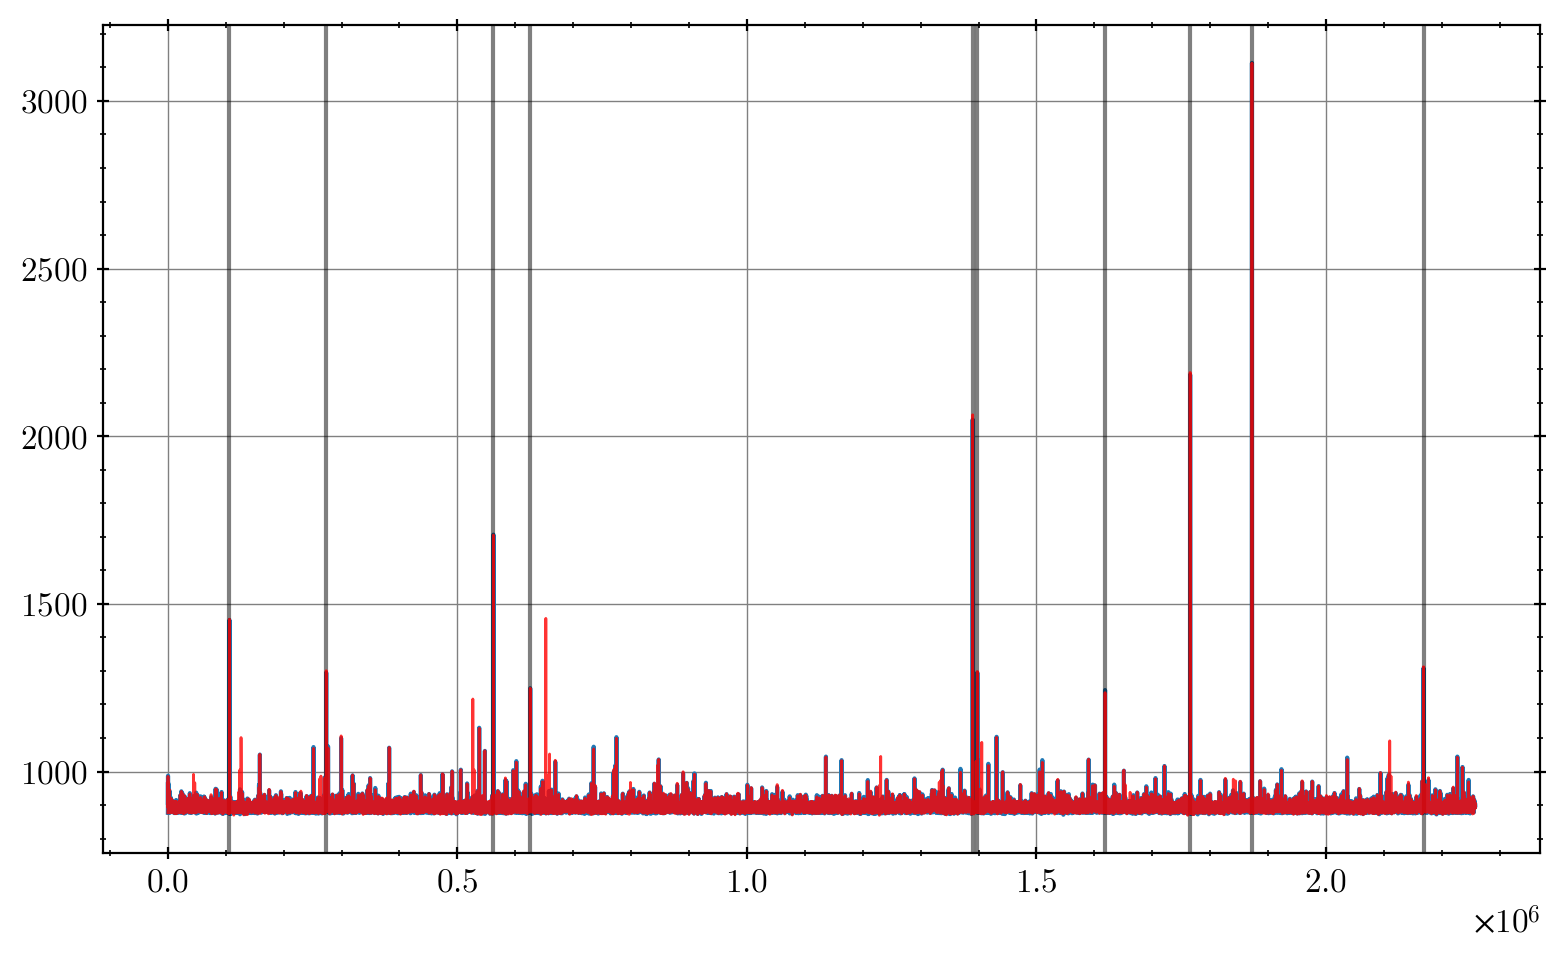

In [182]:
fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=False, sharey=False, gridspec_kw=None)

axs.plot(dark1d)
[axs.axvline(i, color="k", alpha=0.5) for i in idxs]

raveled = np.zeros_like(dark1d)
for i in range(66, 70):
    ccd = yfu.imslice(CCDData.read(summary_dark.loc[i]["file"], unit="adu"), trimsec=TRIMSEC)
    raveled += ccd.data.ravel()
axs.plot(raveled/4, "r", lw=1, alpha=0.8)

plt.tight_layout()
plt.show();

In [179]:
raveled

array([3507., 3580., 3587., ..., 3592., 3588., 3581.], dtype=float32)

In [126]:
# rough read noise in ADU:
rdn_adus = []
for _, row in summary_dark.iterrows():
    if row["EXPTIME"] == 0.5:
        rdn_adus.append(sigma_clipped_stats(CCDData.read(row["file"], unit="adu"))[2])
    
rdn_adu = np.median(rdn_adus)

diff = mdarks[20.].data - mdarks[0.5].data
sigma = 2*rdn_adu/np.sqrt(len(rdn_adus))
mask = diff > 5*sigma
dark_adups = np.zeros_like(diff)
dark_adups[mask] = diff[mask]/19.5
dark_adups = CCDData(dark_adups, header=mdarks[20.].header, unit="adu")
dark_adups.header["EXPTIME"] = 1
dark_adups.write(CALPATH/"dark_adups.fits", overwrite=True, output_verify="fix")

From now on, we can use 
* 0.5-sec master dark as a master bias image.
* ``dark_adups`` as the master dark (with proper scaling with exposure time).

### Master Flat

In [128]:
# Master flat
#   NOTE: all flat files have EXPTIME 1 sec 
ccdred_kw = dict(mbias=mdarks[0.5], mbiaspath=CALPATH/"mdark_0.5.fits",
                 mdark=dark_adups, mdarkpath=CALPATH/"dark_adups.fits",
                 dark_scale=True, output_verify="fix", overwrite=True)
summary_flat = summary.loc[summary["OBJECT"] == "flat"]["file"]
mflat = yfu.imcombine(summary_flat.tolist(), **_medcomb_kw)
mflat = yfu.ccdred(mflat, **ccdred_kw)
normval = np.mean(mflat.data)
mflat.data /= normval
mflat.header.add_history("Normalized by mean")
mflat.header["NORMALIZ"] = ("mean", "Normalized by median")
mflat.header["NORMVAL"] = (normval, "Value used for the normalization")
mflat.write(CALPATH/"mflat.fits", overwrite=True, output_verify="fix")

HISTORY  [yfu.biascor] Bias subtracted (BIASFRM = ../../Tutorial_Data/45P/calib/mdark_0.5.fits)
HISTORY  ..................................(dt = 0.002 s) 2023-09-27T07:16:19.564
HISTORY  [yfu.darkcor] Dark scaled by exptime: (t_data/t_dark) = (1.000/1.000) = 1.000
HISTORY  .................................................2023-09-27T07:16:19.567
HISTORY  [yfu.darkcor] Dark subtracted (DARKFRM = ../../Tutorial_Data/45P/calib/dark_adups.fits)
HISTORY  ..................................(dt = 0.004 s) 2023-09-27T07:16:19.569


### Preprocess



In [129]:
from astropy.stats import sigma_clipped_stats

# rough read noise in ADU:
rdn_adu = sigma_clipped_stats(mdarks[0.5], sigma=3.0, maxiters=5)[2]  

for _, row in summary.iterrows():
    if row["OBJECT"] not in ["DARK", "flat", "comparison"]:
        fpath = Path(row["file"])
        ccd = yfu.imslice(CCDData.read(fpath, unit="adu"), trimsec=TRIMSEC)
        nccd = yfu.ccdred(
            ccd, **ccdred_kw,
            mflat=mflat, mflatpath=CALPATH/"mflat.fits", 
            flat_mask=1.e-2, flat_fill=1.e-2,
            output=REDPATH/f"{fpath.name}", verbose_bdf=0
        )

(2.0871549, 5.219533529217314)

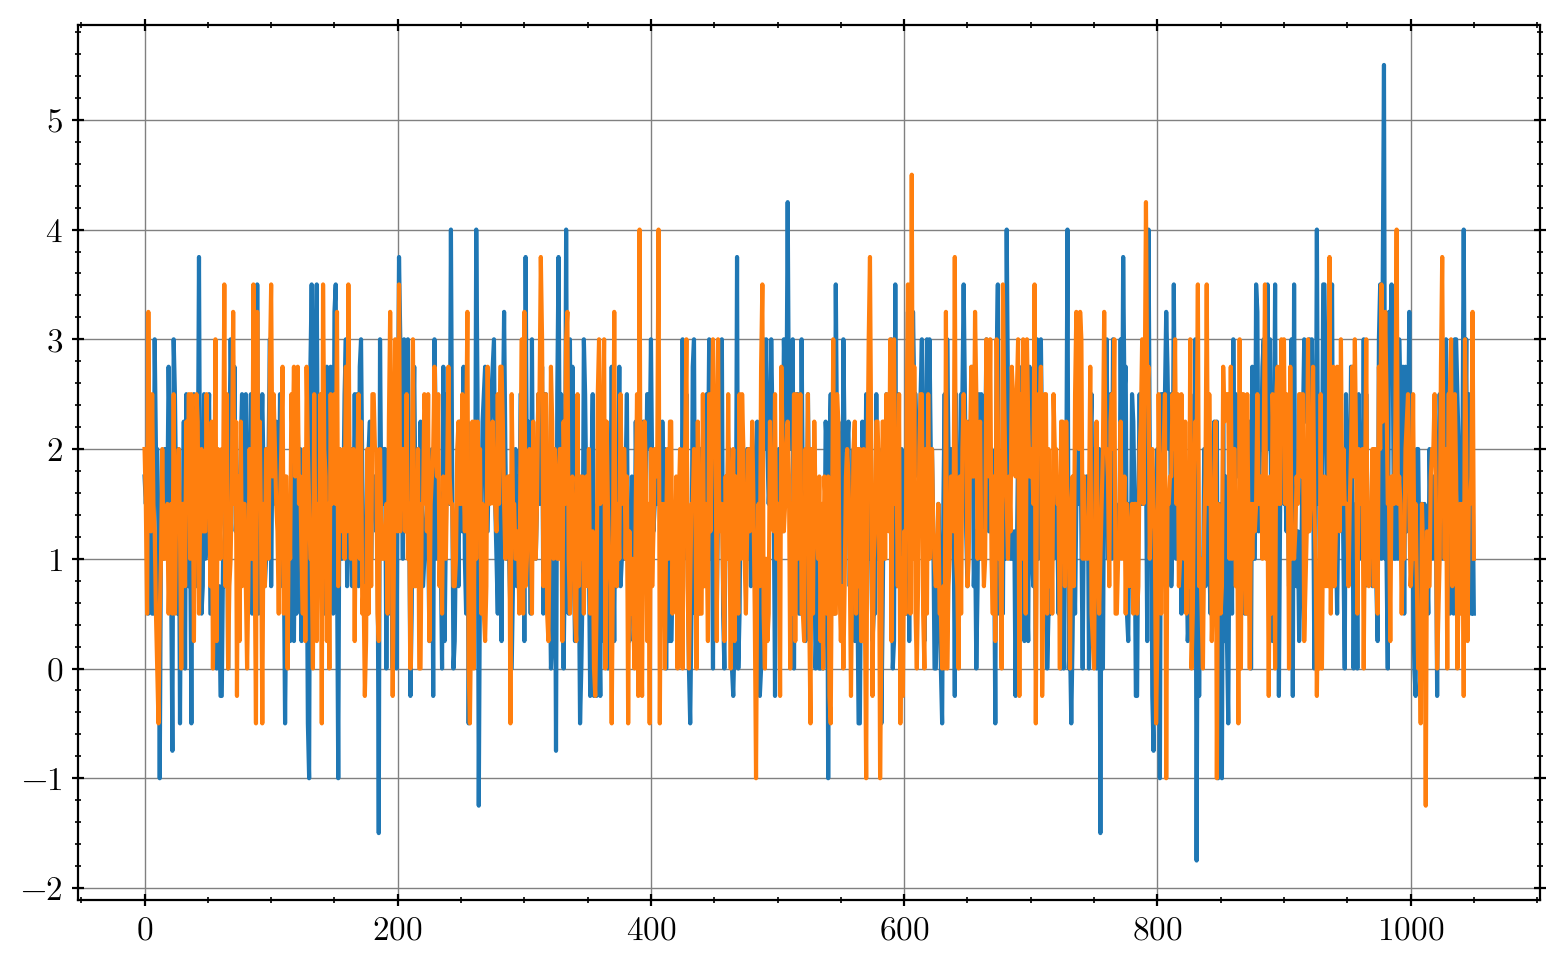

In [89]:
from astropy.stats import sigma_clipped_stats

ccd = CCDData.read(summary["file"].iloc[10], unit="adu")
ccd = yfu.ccdred(
    yfu.imslice(ccd, trimsec=TRIMSEC), mdark=mdark, mdarkpath=mdarkpath,
    mflat=mflat, mflatpath=CALPATH/"mflat.fits", 
    flat_mask=1.e-2, flat_fill=1,
    output=REDPATH/f"{fpath.name}", verbose_bdf=0, overwrite=True
)

fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=False, sharey=False, gridspec_kw=None)

#axs[0].
# axs.imshow(ccd.data[:, 2:50])
# axs.imshow(ccd.data[:, -50:-2])
axs.plot(sigma_clipped_stats(ccd.data[:, 2:50], sigma=3, maxiters=5, axis=1)[1])
axs.plot(sigma_clipped_stats(ccd.data[:, -50:-2], sigma=3, maxiters=5, axis=1)[1])
# axs.plot(sigma_clipped_stats(ccd.data[-50:-2, :]+10, sigma=3, maxiters=5, axis=0)[1])
# axs.plot(sigma_clipped_stats(ccd.data[2:50, :]+10, sigma=3, maxiters=5, axis=0)[1])

axs.set_aspect('auto')


plt.tight_layout()
plt.show();

In [94]:
import _tool_visualization as vis

def mkdark(dark, bias):
    dark = dark.data - bias
    dark[dark < 0] = 0
    return dark

bias = mdarks[0.5].data
mdark600 = mkdark(mdarks[600.], bias)
mdark20 = mkdark(mdarks[20.], bias)
mdark5 = mkdark(mdarks[5.], bias)

nodarkmask = (mdark20 < 10) | (mdark5 < 10)
ratio = mdark20/mdark5
ratio[nodarkmask] = 0

yfu.write2fits(mdark5, header=mdarks[5.].header, output="test.fits", output_verify='fix', overwrite=True)
yfu.write2fits(mdark20, header=mdarks[20.].header, output="test.fits", output_verify='fix', overwrite=True)
yfu.write2fits(ratio, header=mdarks[20.].header, output="test.fits", output_verify='fix', overwrite=True)

yfu.write2fits(mdarks[20.] - mdarks[0.5].data, header=mdarks[20.].header, output="test.fits", output_verify='fix', overwrite=True)


fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=False, sharey=False, gridspec_kw=None)

vis.norm_imshow(axs, ratio)

plt.tight_layout()
plt.show();

/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_5377/2070970336.py:14: RuntimeWarning: divide by zero encountered in divide
  ratio = mdark20/mdark5
/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_5377/2070970336.py:14: RuntimeWarning: invalid value encountered in divide
  ratio = mdark20/mdark5
